# Análisis Exploratorio de Datos (EDA) - Dataset de Compras Black Sales

## 2a) EDA y preparación del dataset

En este análisis vamos a:
1. Explorar el dataset de compras realizadas durante un black sales
2. Realizar el pre-procesamiento necesario
3. Crear segmentos de clientes basados en el gasto
4. Preparar los datos para clasificación

In [ ]:
# Importar librerías necesarias
import time
import torch
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from collections import defaultdict

warnings.filterwarnings('ignore')
# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# Cargar el dataset
df = pd.read_csv('data/dataset_compras.csv')

# Información básica del dataset
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")
print()

print("=== TIPOS DE DATOS ===")
print(df.dtypes)
print()

print("=== PRIMERAS 5 FILAS ===")
df.head()

=== INFORMACIÓN GENERAL DEL DATASET ===
Dimensiones del dataset: (182721, 11)
Número de filas: 182,721
Número de columnas: 11

=== TIPOS DE DATOS ===
User_ID                         int64
Product_ID                     object
Age                            object
Gender                         object
Marital_Status                  int64
City_Category                  object
Stay_In_Current_City_Years     object
Product_Category                int64
Product_Subcategory_1         float64
Product_Subcategory_2         float64
Purchase                        int64
dtype: object

=== PRIMERAS 5 FILAS ===


,User_ID,Product_ID,Age,Gender,Marital_Status,City_Category,Stay_In_Current_City_Years,Product_Category,Product_Subcategory_1,Product_Subcategory_2,Purchase
0,1044096,P00017122,46-50,F,1,B,1,10,45.0,NaN,1810
1,1071818,P00074517,36-45,M,0,A,3,11,27.0,NaN,12351
2,1022986,P00013694,36-45,M,1,A,5+,4,28.0,NaN,127
3,1094684,P00049122,36-45,M,1,A,1,16,9.0,8.0,2214
4,1004157,P00006469,46-50,M,1,A,5+,3,NaN,NaN,7142


In [3]:
# Análisis de valores nulos
print("=== VALORES NULOS ===")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Nulos': missing_values.values,
    'Porcentaje_Nulo': missing_percentage.values
}).sort_values('Porcentaje_Nulo', ascending=False)
print(missing_df)
print()

print("=== ESTADÍSTICAS DESCRIPTIVAS ===")
print("Variables numéricas:")
print(df.describe())
print()

print("=== INFORMACIÓN DE COLUMNAS CATEGÓRICAS ===")
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\n{col}:")
    print(f"  Valores únicos: {df[col].nunique()}")
    print(f"  Valores: {df[col].unique()[:10]}")  # Solo primeros 10 valores

=== VALORES NULOS ===
                       Columna  Valores_Nulos  Porcentaje_Nulo
9        Product_Subcategory_2         105260        57.606953
8        Product_Subcategory_1          41818        22.886258
0                      User_ID              0         0.000000
2                          Age              0         0.000000
1                   Product_ID              0         0.000000
3                       Gender              0         0.000000
4               Marital_Status              0         0.000000
6   Stay_In_Current_City_Years              0         0.000000
5                City_Category              0         0.000000
7             Product_Category              0         0.000000
10                    Purchase              0         0.000000

=== ESTADÍSTICAS DESCRIPTIVAS ===
Variables numéricas:
            User_ID  Marital_Status  Product_Category  Product_Subcategory_1  \
count  1.827210e+05   182721.000000     182721.000000          140903.000000   
mean  

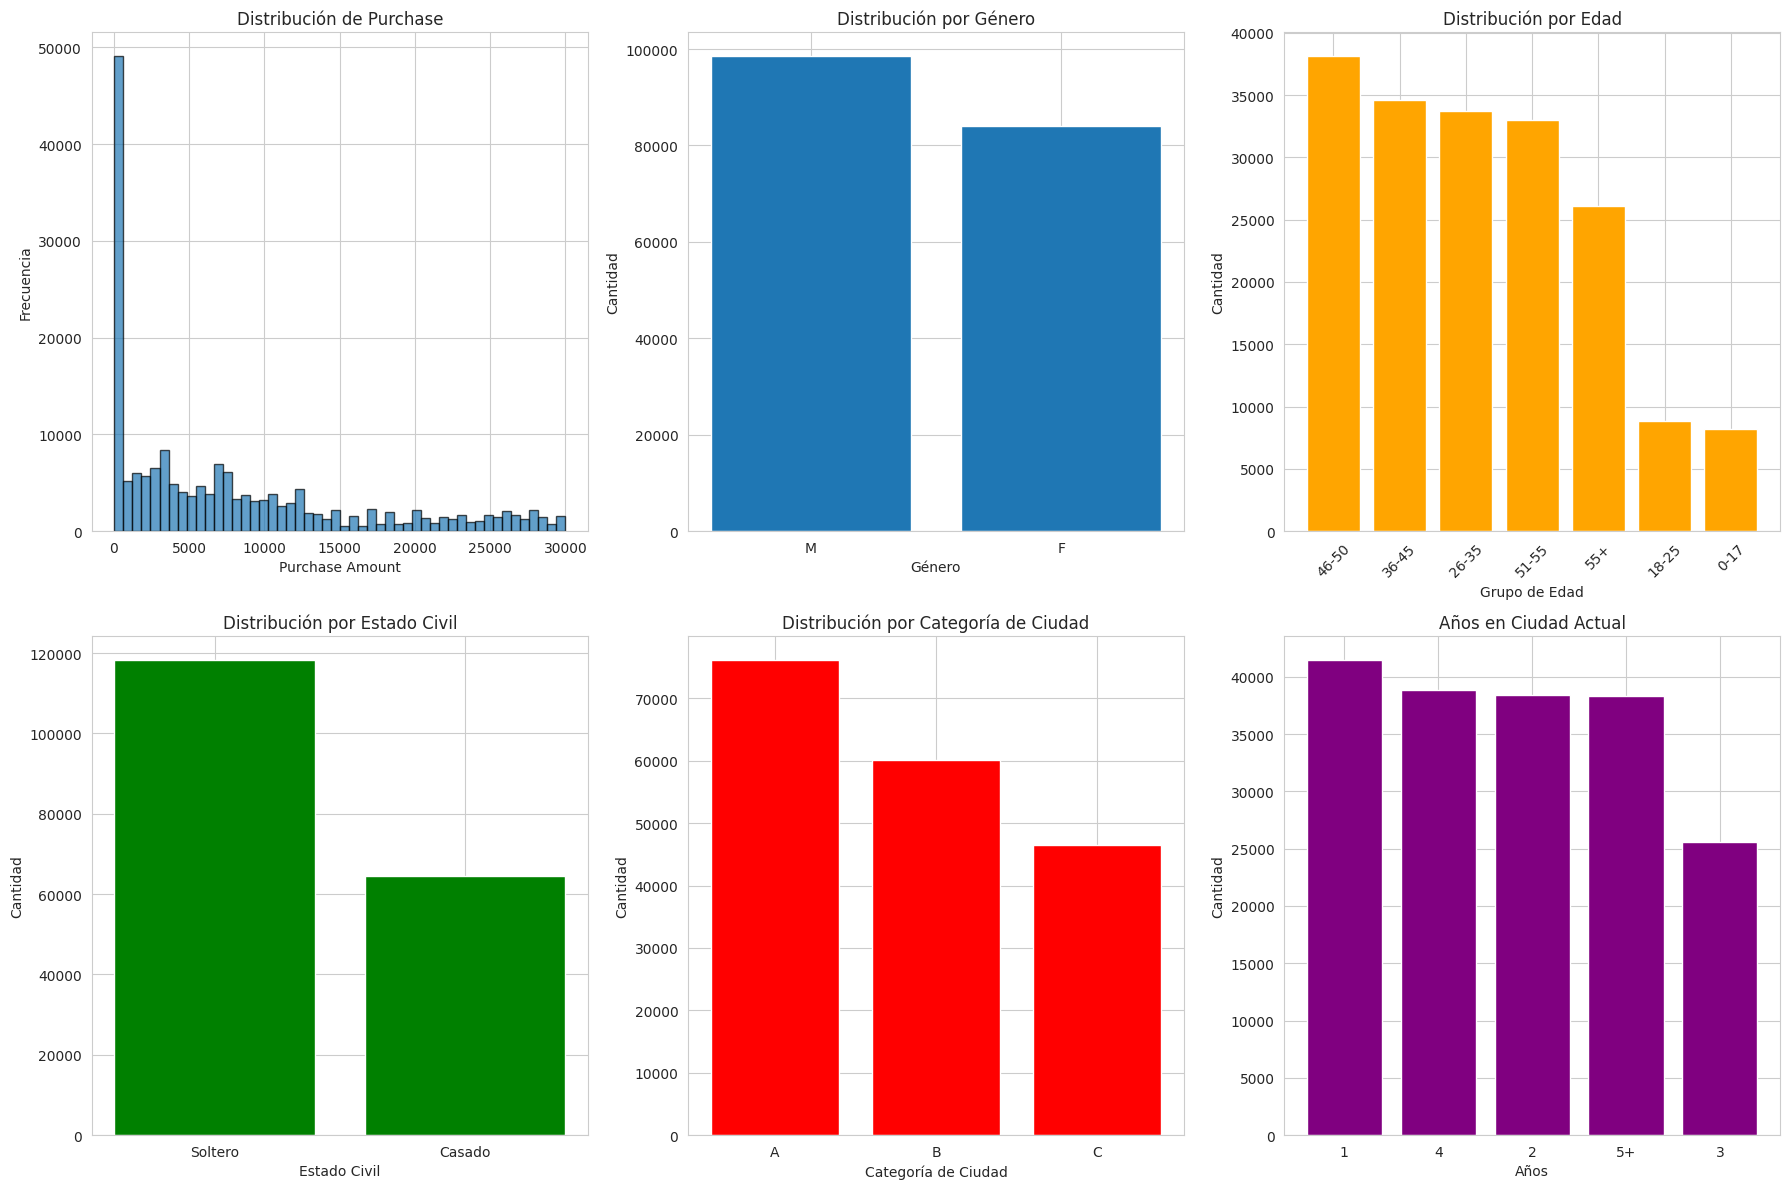

In [4]:
# Visualizaciones de las distribuciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución de Purchase (variable objetivo)
axes[0, 0].hist(df['Purchase'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Purchase')
axes[0, 0].set_xlabel('Purchase Amount')
axes[0, 0].set_ylabel('Frecuencia')

# Distribución por Género
gender_counts = df['Gender'].value_counts()
axes[0, 1].bar(gender_counts.index, gender_counts.values)
axes[0, 1].set_title('Distribución por Género')
axes[0, 1].set_xlabel('Género')
axes[0, 1].set_ylabel('Cantidad')

# Distribución por Edad
age_counts = df['Age'].value_counts()
axes[0, 2].bar(age_counts.index, age_counts.values, color='orange')
axes[0, 2].set_title('Distribución por Edad')
axes[0, 2].set_xlabel('Grupo de Edad')
axes[0, 2].set_ylabel('Cantidad')
axes[0, 2].tick_params(axis='x', rotation=45)

# Distribución por Estado Civil
marital_counts = df['Marital_Status'].value_counts()
axes[1, 0].bar(['Soltero', 'Casado'], marital_counts.values, color='green')
axes[1, 0].set_title('Distribución por Estado Civil')
axes[1, 0].set_xlabel('Estado Civil')
axes[1, 0].set_ylabel('Cantidad')

# Distribución por Categoría de Ciudad
city_counts = df['City_Category'].value_counts()
axes[1, 1].bar(city_counts.index, city_counts.values, color='red')
axes[1, 1].set_title('Distribución por Categoría de Ciudad')
axes[1, 1].set_xlabel('Categoría de Ciudad')
axes[1, 1].set_ylabel('Cantidad')

# Años en la ciudad actual
years_counts = df['Stay_In_Current_City_Years'].value_counts()
axes[1, 2].bar(years_counts.index, years_counts.values, color='purple')
axes[1, 2].set_title('Años en Ciudad Actual')
axes[1, 2].set_xlabel('Años')
axes[1, 2].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

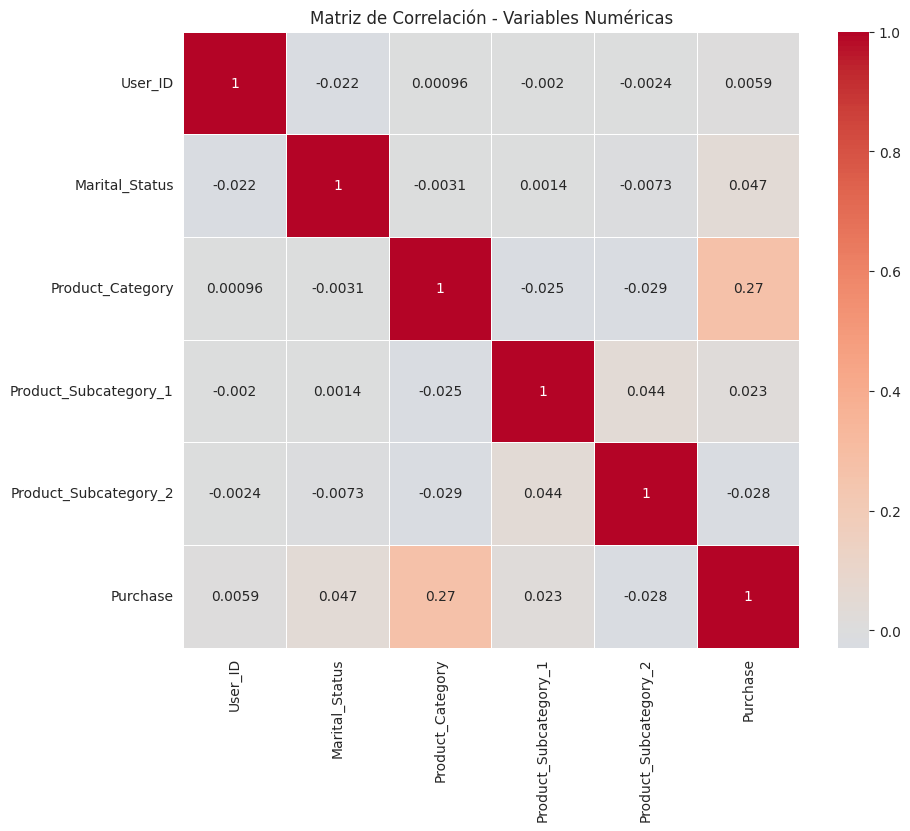

In [5]:
# Análisis de correlaciones entre variables numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matriz de Correlación - Variables Numéricas')
plt.show()

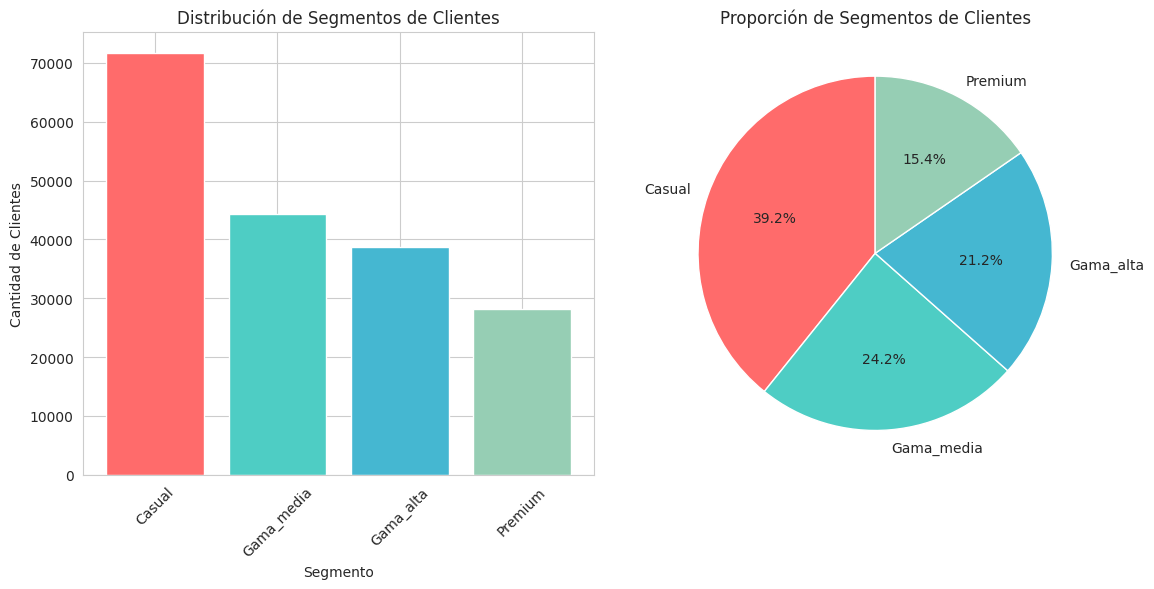

In [6]:
# Crear segmentos de clientes basados en Purchase
def crear_segmento(purchase):
    if purchase < 3000:
        return 'Casual'
    elif 3000 <= purchase < 8000:
        return 'Gama_media'
    elif 8000 <= purchase < 18000:
        return 'Gama_alta'
    else:
        return 'Premium'

# Aplicar la función para crear la nueva columna de segmentos
df['Segmento'] = df['Purchase'].apply(crear_segmento)

# Analizar la distribución de segmentos
segmento_counts = df['Segmento'].value_counts()
segmento_percentage = (segmento_counts / len(df)) * 100

segmento_df = pd.DataFrame({
    'Segmento': segmento_counts.index,
    'Cantidad': segmento_counts.values,
    'Porcentaje': segmento_percentage.values
})


# Visualización de la distribución de segmentos
plt.figure(figsize=(12, 6))

# Gráfico de barras
plt.subplot(1, 2, 1)
plt.bar(segmento_counts.index, segmento_counts.values, 
        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('Distribución de Segmentos de Clientes')
plt.xlabel('Segmento')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=45)

# Gráfico circular
plt.subplot(1, 2, 2)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
plt.pie(segmento_counts.values, labels=segmento_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Proporción de Segmentos de Clientes')

plt.tight_layout()
plt.show()

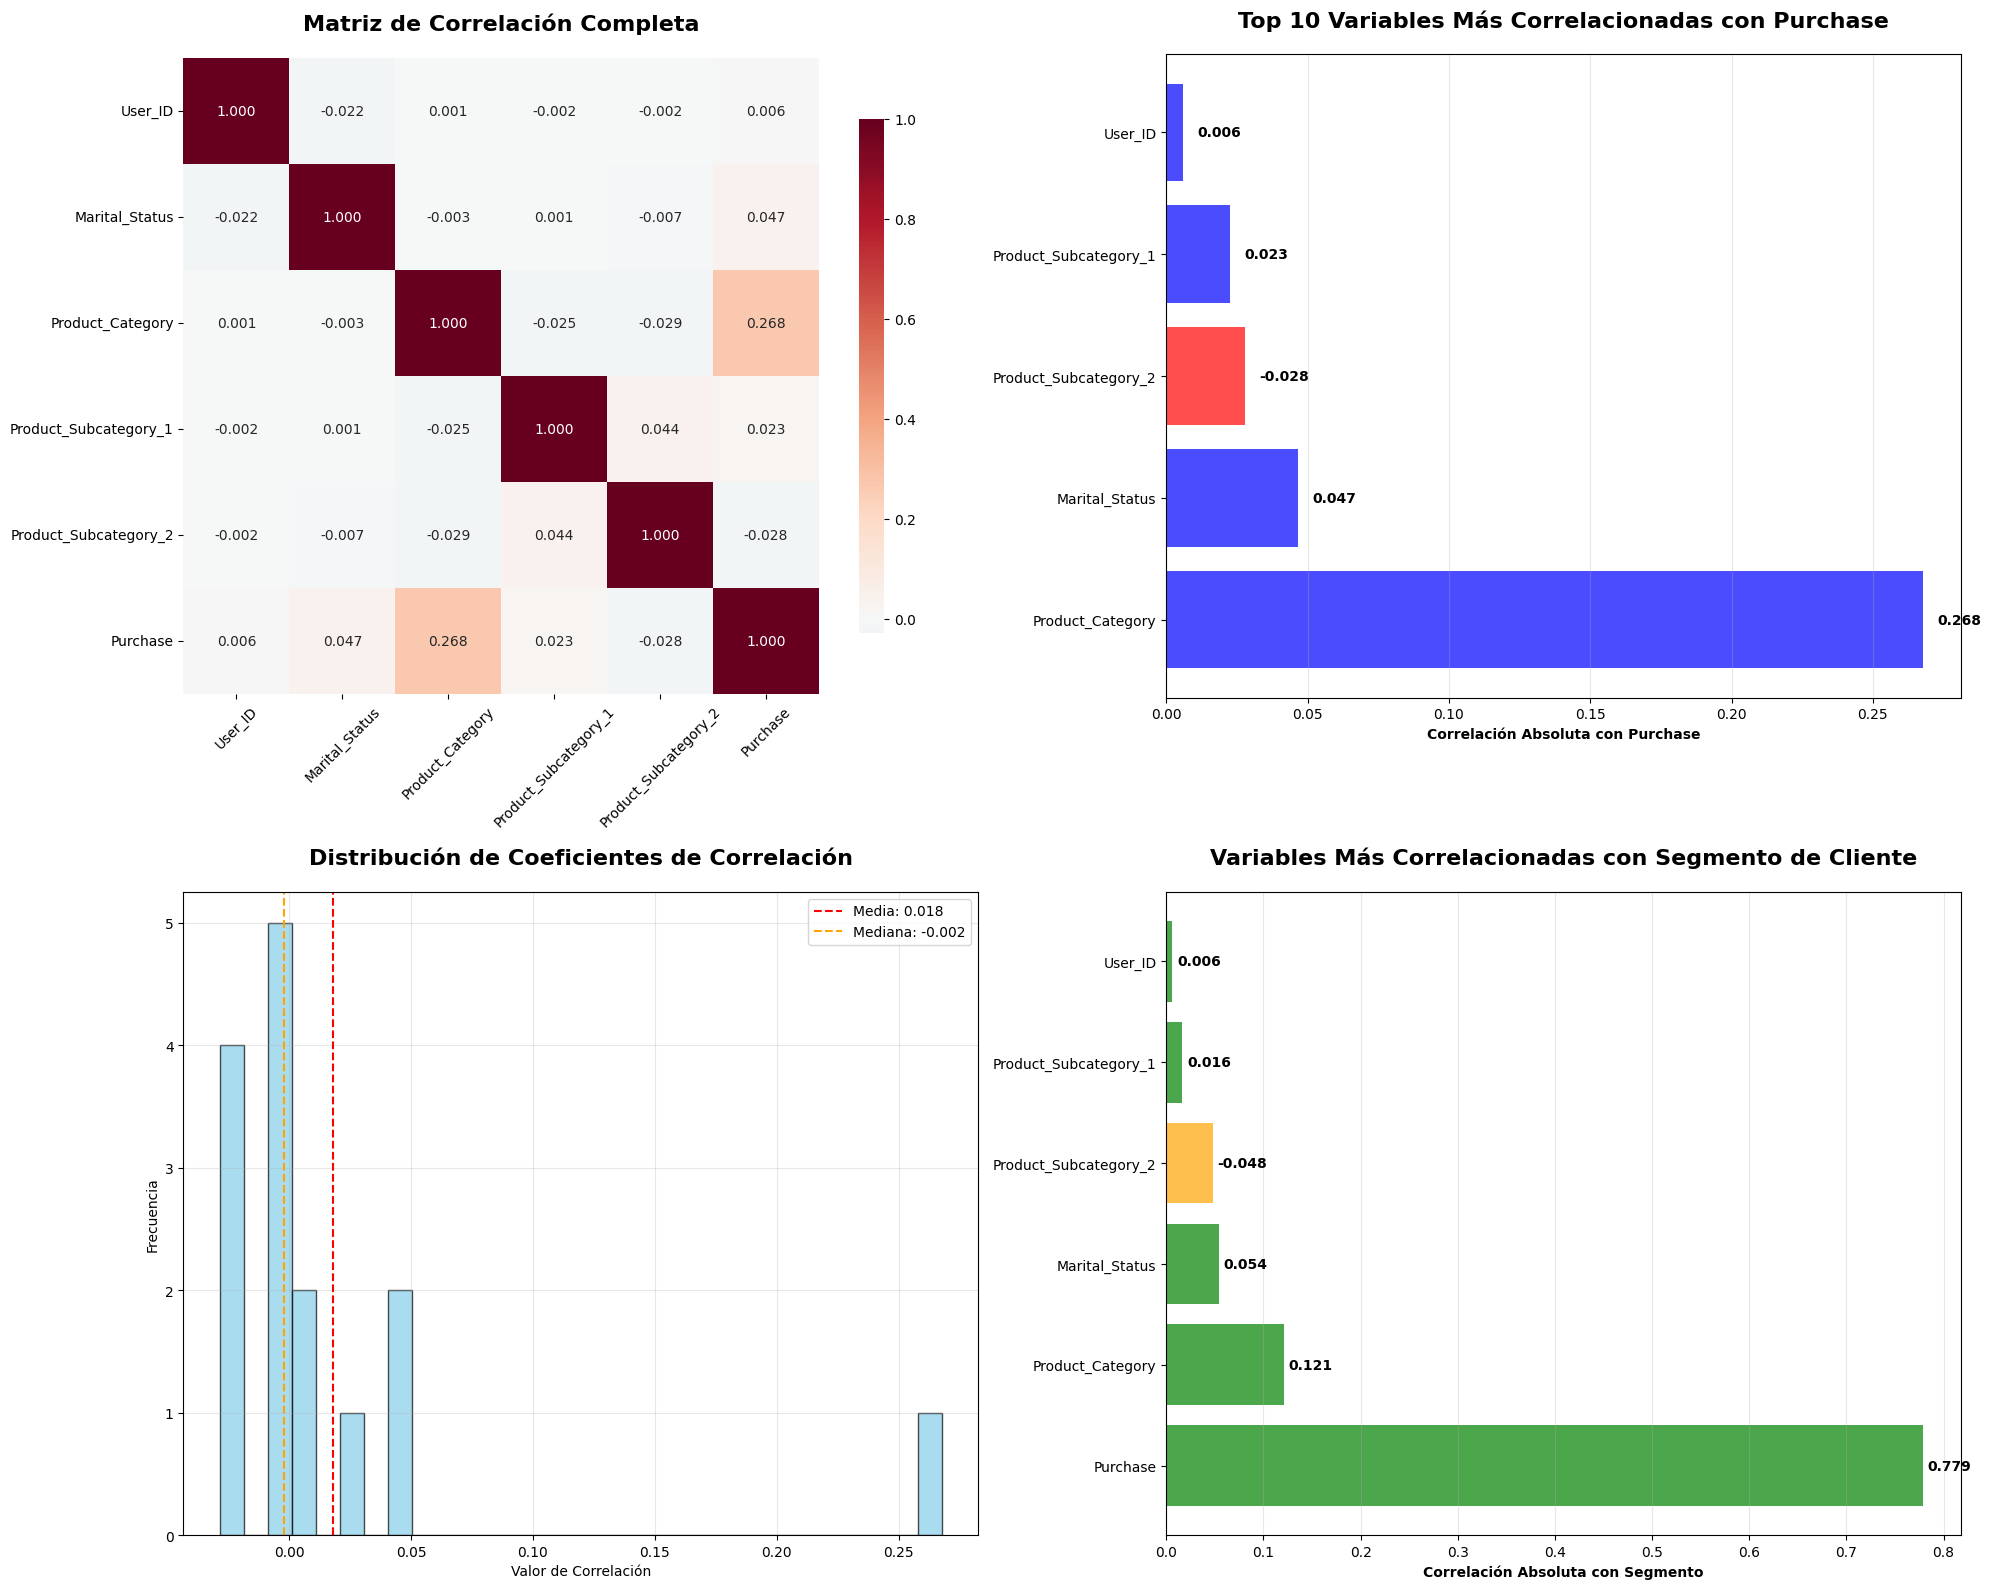

In [ ]:
# VISUALIZACIONES Y ANÁLISIS DE CORRELACIÓN
plt.style.use('default')
sns.set_palette("husl")

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. HEATMAP DE CORRELACIÓN COMPLETO
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', square=True, ax=axes[0,0], cbar_kws={'shrink': .8})
axes[0,0].set_title('Matriz de Correlación Completa', fontsize=16, fontweight='bold', pad=20)
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].tick_params(axis='y', rotation=0)

# Limpiar etiquetas (quitar '_encoded')
x_labels = [label.get_text().replace('_encoded', '') for label in axes[0,0].get_xticklabels()]
y_labels = [label.get_text().replace('_encoded', '') for label in axes[0,0].get_yticklabels()]
axes[0,0].set_xticklabels(x_labels)
axes[0,0].set_yticklabels(y_labels)

# 2. CORRELACIONES CON PURCHASE
purchase_corr = correlation_matrix['Purchase'].abs().sort_values(ascending=False)
purchase_corr_display = purchase_corr[purchase_corr.index != 'Purchase'].head(10)

colors = ['red' if correlation_matrix['Purchase'][var] < 0 else 'blue' for var in purchase_corr_display.index]
bars = axes[0,1].barh(range(len(purchase_corr_display)), purchase_corr_display.values, color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(purchase_corr_display)))
axes[0,1].set_yticklabels([x.replace('_encoded', '') for x in purchase_corr_display.index])
axes[0,1].set_xlabel('Correlación Absoluta con Purchase', fontweight='bold')
axes[0,1].set_title('Top 10 Variables Más Correlacionadas con Purchase', fontsize=16, fontweight='bold', pad=20)
axes[0,1].grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, purchase_corr_display.values)):
    actual_corr = correlation_matrix['Purchase'][purchase_corr_display.index[i]]
    axes[0,1].text(val + 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{actual_corr:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)

# 3. DISTRIBUCIÓN DE VALORES DE CORRELACIÓN
corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
axes[1,0].hist(corr_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,0].axvline(np.mean(corr_values), color='red', linestyle='--', 
                  label=f'Media: {np.mean(corr_values):.3f}')
axes[1,0].axvline(np.median(corr_values), color='orange', linestyle='--', 
                  label=f'Mediana: {np.median(corr_values):.3f}')
axes[1,0].set_xlabel('Valor de Correlación')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Coeficientes de Correlación', fontsize=16, fontweight='bold', pad=20)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. CORRELACIÓN CON SEGMENTO
if 'Segmento' in df.columns:
    from sklearn.preprocessing import LabelEncoder
    segmento_encoder = LabelEncoder()
    df_temp = df.copy()
    df_temp['Segmento_encoded'] = segmento_encoder.fit_transform(df['Segmento'])
    
    numeric_cols_with_segmento = df_temp.select_dtypes(include=[np.number]).columns
    corr_with_segmento = df_temp[numeric_cols_with_segmento].corr()['Segmento_encoded'].abs().sort_values(ascending=False)
    corr_with_segmento = corr_with_segmento[corr_with_segmento.index != 'Segmento_encoded'].head(8)
    
    colors_seg = ['green' if df_temp[numeric_cols_with_segmento].corr()['Segmento_encoded'][var] > 0 else 'orange' 
                  for var in corr_with_segmento.index]
    
    bars_seg = axes[1,1].barh(range(len(corr_with_segmento)), corr_with_segmento.values, 
                              color=colors_seg, alpha=0.7)
    axes[1,1].set_yticks(range(len(corr_with_segmento)))
    axes[1,1].set_yticklabels([x.replace('_encoded', '') for x in corr_with_segmento.index])
    axes[1,1].set_xlabel('Correlación Absoluta con Segmento', fontweight='bold')
    axes[1,1].set_title('Variables Más Correlacionadas con Segmento de Cliente', fontsize=16, fontweight='bold', pad=20)
    axes[1,1].grid(True, alpha=0.3, axis='x')
    
    for i, (bar, val) in enumerate(zip(bars_seg, corr_with_segmento.values)):
        actual_corr_seg = df_temp[numeric_cols_with_segmento].corr()['Segmento_encoded'][corr_with_segmento.index[i]]
        axes[1,1].text(val + 0.005, bar.get_y() + bar.get_height()/2, 
                       f'{actual_corr_seg:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)
else:
    upper_tri = np.triu_indices_from(correlation_matrix, k=1)
    corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i,j]) 
                  for i, j in zip(upper_tri[0], upper_tri[1])]
    corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:8]
    
    pair_labels = [f"{pair[0].replace('_encoded', '')} - {pair[1].replace('_encoded', '')}" 
                   for pair in corr_pairs_sorted]
    pair_values = [abs(pair[2]) for pair in corr_pairs_sorted]
    pair_colors = ['green' if pair[2] > 0 else 'orange' for pair in corr_pairs_sorted]
    
    bars_pairs = axes[1,1].barh(range(len(pair_values)), pair_values, color=pair_colors, alpha=0.7)
    axes[1,1].set_yticks(range(len(pair_values)))
    axes[1,1].set_yticklabels(pair_labels, fontsize=10)
    axes[1,1].set_xlabel('Correlación Absoluta', fontweight='bold')
    axes[1,1].set_title('Pares de Variables con Mayor Correlación', fontsize=16, fontweight='bold', pad=20)
    axes[1,1].grid(True, alpha=0.3, axis='x')
    
    for i, (bar, pair) in enumerate(zip(bars_pairs, corr_pairs_sorted)):
        axes[1,1].text(abs(pair[2]) + 0.005, bar.get_y() + bar.get_height()/2, 
                       f'{pair[2]:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


In [38]:
print("ANALISIS DE VALORES NULOS")

missing_analysis = pd.DataFrame({
    'Variable': df.columns,
    'Total_Nulos': df.isnull().sum(),
    'Porcentaje_Nulos': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_analysis = missing_analysis.sort_values('Porcentaje_Nulos', ascending=False)

print("\nDistribucion de valores nulos:")
print(missing_analysis[missing_analysis['Total_Nulos'] > 0])

vars_con_nulos = missing_analysis[missing_analysis['Total_Nulos'] > 0]['Variable'].tolist()

if len(vars_con_nulos) >= 2:
    df_nulos = df[vars_con_nulos].isnull()
    patrones_nulos = df_nulos.value_counts().head(4)
    print("\nPatrones de valores nulos:")
    for patron, count in patrones_nulos.items():
        print(f"  {patron}: {count:,} casos ({count/len(df)*100:.1f}%)")

for var_nulo in vars_con_nulos:
    if var_nulo not in ['User_ID', 'Product_ID']:
        total_productos = df['Product_ID'].nunique()
        productos_con_nulos = df[df[var_nulo].isnull()]['Product_ID'].nunique()
        pct_productos_afectados = (productos_con_nulos / total_productos) * 100
        
        if pct_productos_afectados > 30:
            tipo_nulo = "MNAR - Sistematico"
        elif pct_productos_afectados > 80:
            tipo_nulo = "MAR - Dependiente"
        else:
            tipo_nulo = "MCAR - Aleatorio"
        
        print(f"\n{var_nulo}: {pct_productos_afectados:.1f}% productos afectados - {tipo_nulo}")

print("\nAnalisis completado")

ANALISIS DE VALORES NULOS

Distribucion de valores nulos:
                                    Variable  Total_Nulos  Porcentaje_Nulos
Product_Subcategory_2  Product_Subcategory_2       105260             57.61
Product_Subcategory_1  Product_Subcategory_1        41818             22.89

Patrones de valores nulos:
  (True, False): 81,280 casos (44.5%)
  (False, False): 59,623 casos (32.6%)
  (True, True): 23,980 casos (13.1%)
  (False, True): 17,838 casos (9.8%)

Product_Subcategory_2: 57.0% productos afectados - MNAR - Sistematico

Product_Subcategory_1: 23.0% productos afectados - MCAR - Aleatorio

Analisis completado


# 2b) Modelo de Deep Learning sin Embeddings

En esta sección vamos a:
1. Preparar los datos para el entrenamiento
2. Crear una arquitectura de red neuronal usando PyTorch
3. Entrenar el modelo con técnicas de regularización
4. Evaluar el rendimiento y crear visualizaciones
5. Optimizar hiperparámetros para alcanzar el objetivo de 78% accuracy y F1-score
## Optimización Final del Modelo ImprovedCustomerSegmentationNet

Vamos a aplicar técnicas avanzadas de regularización al modelo que mejor rendimiento mostró:
1. **Regularización L1 + L2 (Elastic Net)**
2. **Dropout mejorado con tasas progresivas**
3. **Learning Rate Scheduler avanzado (OneCycleLR)**
4. **Early Stopping más preciso**
5. **Gradient Clipping**

In [ ]:
# separar características y variable objetivo
X = df.drop(['Purchase', 'Segmento', 'User_ID', 'Product_ID'], axis=1)
y = df['Segmento']

# dividir dataset: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)


# obtener los Product_ID correspondientes para cada conjunto
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

# 1 calcular estadísticas del conjunto de entrenamiento
train_product_frequency = df.loc[train_indices, 'Product_ID'].value_counts().to_dict()
train_product_purchase_mean = df.loc[train_indices].groupby('Product_ID')['Purchase'].mean().to_dict()


# 2 aplicar las estadísticas a todos los conjuntos
default_frequency = 1 

# Train set
X_train = X_train.copy()
X_train['Product_Frequency'] = df.loc[train_indices, 'Product_ID'].map(train_product_frequency).fillna(default_frequency)

# Validation set
X_val = X_val.copy()
X_val['Product_Frequency'] = df.loc[val_indices, 'Product_ID'].map(train_product_frequency).fillna(default_frequency)

# Test set
X_test = X_test.copy()
X_test['Product_Frequency'] = df.loc[test_indices, 'Product_ID'].map(train_product_frequency).fillna(default_frequency)

# Verificar productos no vistos
unseen_val = sum(df.loc[val_indices, 'Product_ID'].map(train_product_frequency).isna())
unseen_test = sum(df.loc[test_indices, 'Product_ID'].map(train_product_frequency).isna())
print(f"Productos no vistos en entrenamiento - Val: {unseen_val}, Test: {unseen_test}")
print(f"Valores por defecto aplicados - Frequency: {default_frequency}")

print(f"\nTrain: {X_train.shape[0]} | Validation: {X_val.shape[0]} | Test: {X_test.shape[0]}")

# Definir columnas por tipo
numeric_cols = ['Marital_Status', 'Product_Category', 'Product_Subcategory_1', 'Product_Subcategory_2', 
                'Product_Frequency']
categorical_nominal = ['Gender', 'City_Category']
categorical_ordinal = ['Age', 'Stay_In_Current_City_Years']

# Configurar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat_nom', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_nominal),
        ('cat_ord', OrdinalEncoder(
            categories=[
                ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'],
                ['1', '2', '3', '4', '5+']
            ],
            handle_unknown='use_encoded_value', 
            unknown_value=-1
        ), categorical_ordinal)
    ]
)

# Transformar datos
X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)

# Estrategia de imputación
imputer = SimpleImputer(strategy='constant', fill_value=-999)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Codificar target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

print(f"\nShape final - Features: {X_train_scaled.shape[1]} | Classes: {len(le.classes_)}")
print(f"Clases: {le.classes_}")
print(f"Distribución train: {np.bincount(y_train_encoded)}")
print(f"Distribución val: {np.bincount(y_val_encoded)}")
print(f"Distribución test: {np.bincount(y_test_encoded)}")

Productos no vistos en entrenamiento - Val: 0, Test: 0
Valores por defecto aplicados - Frequency: 1, Purchase_Mean: 7851.44

Train: 127977 | Validation: 27335 | Test: 27409

Shape final - Features: 10 | Classes: 4
Clases: ['Casual' 'Gama_alta' 'Gama_media' 'Premium']
Distribución train: [50217 27068 31003 19689]
Distribución val: [10726  5781  6622  4206]
Distribución test: [10755  5797  6640  4217]


In [ ]:
# PARÁMETROS DE CONFIGURACIÓN
EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 0.001
MAX_LR = 0.01
WEIGHT_DECAY = 1e-4
L1_LAMBDA = 1e-5
PATIENCE = 10
MAX_GRAD_NORM = 1.0
LABEL_SMOOTHING = 0.1
NUM_WORKERS = 2

# ARQUITECTURA DEL MODELO
INPUT_SIZE = X_train_scaled.shape[1]  # Tamaño dinámico basado en características finales
HIDDEN_LAYERS = [512, 256, 128, 64, 32]
NUM_CLASSES = 4
DROPOUT_RATES = [0.3, 0.4, 0.5, 0.6, 0.7]

class CustomerDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class DeepCustomerSegmentationNet(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_layers=HIDDEN_LAYERS, 
                 num_classes=NUM_CLASSES, dropout_rates=DROPOUT_RATES):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        prev_size = input_size
        for i, (hidden_size, dropout_rate) in enumerate(zip(hidden_layers, dropout_rates)):
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.batch_norms.append(nn.BatchNorm1d(hidden_size))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        self.output_layer = nn.Linear(prev_size, num_classes)
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = F.relu(bn(layer(x)))
            x = dropout(x)
        x = self.output_layer(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

train_dataset = CustomerDataset(X_train_scaled, y_train_encoded)
val_dataset = CustomerDataset(X_val_scaled, y_val_encoded)
test_dataset = CustomerDataset(X_test_scaled, y_test_encoded)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = DeepCustomerSegmentationNet().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=15, min_lr=1e-6)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")
print(f"Arquitectura: {INPUT_SIZE} -> {' -> '.join(map(str, HIDDEN_LAYERS))} -> {NUM_CLASSES}")

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return acc, f1, precision, recall

def train_epoch(model, loader, criterion, optimizer, device, l1_lambda=L1_LAMBDA):
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []
    
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_GRAD_NORM)
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    acc, f1, precision, recall = compute_metrics(all_targets, all_preds)
    return avg_loss, acc, f1, precision, recall

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    acc, f1, precision, recall = compute_metrics(all_targets, all_preds)
    return avg_loss, acc, f1, precision, recall

epochs = EPOCHS
best_f1 = 0
patience = PATIENCE
patience_counter = 0
best_model = None

metrics = defaultdict(list)

print(f"\nIniciando entrenamiento por {epochs} épocas...")
print("Epoch | Train Loss | Train Acc | Train F1 | Val Loss | Val Acc | Val F1 | LR")
print("-" * 85)

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_prec, train_rec = train_epoch(
        model, train_loader, criterion, optimizer, device)
    
    val_loss, val_acc, val_f1, val_prec, val_rec = validate_epoch(
        model, val_loader, criterion, device)
    
    scheduler.step(val_f1)
    current_lr = optimizer.param_groups[0]['lr']
    
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['train_f1'].append(train_f1)
    metrics['train_precision'].append(train_prec)
    metrics['train_recall'].append(train_rec)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    metrics['val_f1'].append(val_f1)
    metrics['val_precision'].append(val_prec)
    metrics['val_recall'].append(val_rec)
    metrics['learning_rate'].append(current_lr)
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"{epoch+1:5d} | {train_loss:10.4f} | {train_acc:9.4f} | "
              f"{train_f1:8.4f} | {val_loss:8.4f} | {val_acc:7.4f} | {val_f1:6.4f} | {current_lr:.2e}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model)
test_loss, test_acc, test_f1, test_prec, test_rec = validate_epoch(
    model, test_loader, criterion, device)

torch.save(best_model, 'best_deep_model.pth')

Dispositivo utilizado: cuda
Modelo creado con 182308 parámetros
Arquitectura: 10 -> 512 -> 256 -> 128 -> 64 -> 32 -> 4

Iniciando entrenamiento por 50 épocas...
Epoch | Train Loss | Train Acc | Train F1 | Val Loss | Val Acc | Val F1 | LR
-------------------------------------------------------------------------------------


   10 |     0.8673 |    0.7801 |   0.7718 |   0.6529 |  0.8400 | 0.8371 | 1.00e-03
   20 |     0.8175 |    0.8014 |   0.7943 |   0.6256 |  0.8504 | 0.8481 | 1.00e-03
   20 |     0.8175 |    0.8014 |   0.7943 |   0.6256 |  0.8504 | 0.8481 | 1.00e-03
   30 |     0.8072 |    0.8056 |   0.7984 |   0.6177 |  0.8519 | 0.8491 | 1.00e-03
   30 |     0.8072 |    0.8056 |   0.7984 |   0.6177 |  0.8519 | 0.8491 | 1.00e-03
   40 |     0.7930 |    0.8116 |   0.8046 |   0.6139 |  0.8545 | 0.8517 | 1.00e-03
   40 |     0.7930 |    0.8116 |   0.8046 |   0.6139 |  0.8545 | 0.8517 | 1.00e-03
   50 |     0.7905 |    0.8133 |   0.8068 |   0.6159 |  0.8528 | 0.8498 | 1.00e-03
Early stopping at epoch 50
   50 |     0.7905 |    0.8133 |   0.8068 |   0.6159 |  0.8528 | 0.8498 | 1.00e-03
Early stopping at epoch 50

Resultados finales del modelo profundo:
Test Accuracy: 0.8553
Test F1-Score: 0.8525
Test Precision: 0.8709
Test Recall: 0.8553
Mejor F1 en validación: 0.8517

Resultados finales del modelo profundo:

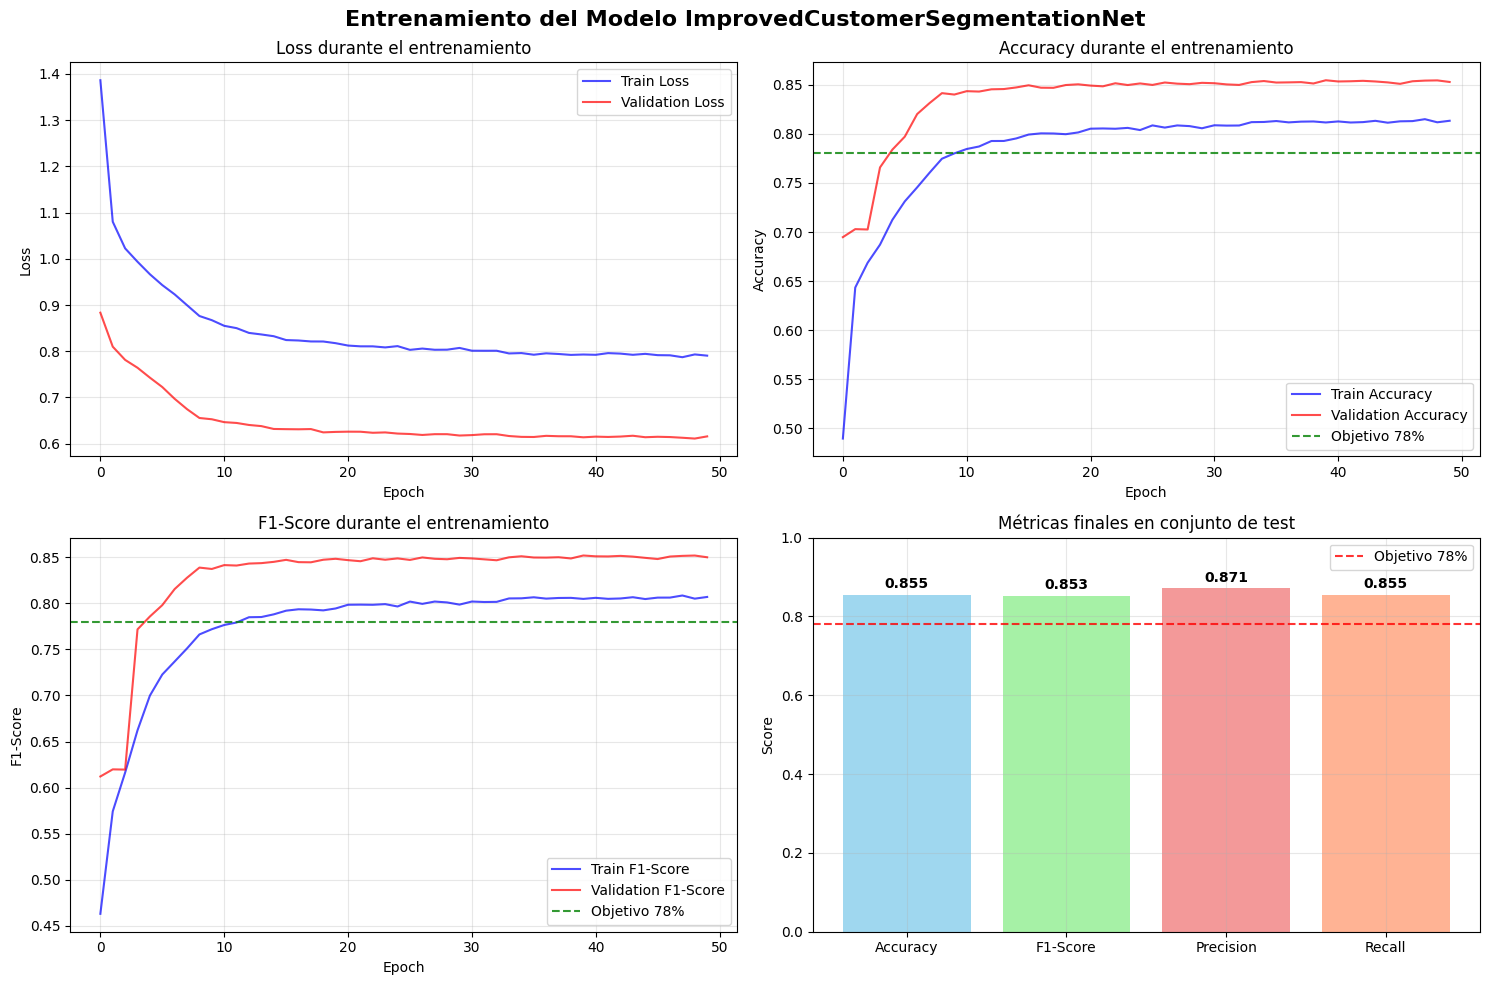


Reporte de clasificación detallado:
              precision    recall  f1-score   support

      Casual     0.9353    0.9953    0.9644     10755
   Gama_alta     0.7708    0.6586    0.7103      5797
  Gama_media     0.9760    0.7157    0.8258      6640
     Premium     0.6788    0.9889    0.8050      4217

    accuracy                         0.8553     27409
   macro avg     0.8402    0.8396    0.8264     27409
weighted avg     0.8709    0.8553    0.8525     27409


Resumen del modelo:
Arquitectura: Red neuronal con 4 capas densas + BatchNorm + Dropout
Regularización: L1 + L2 + Dropout progresivo + Label Smoothing
Optimizador: AdamW con OneCycleLR scheduler
Early Stopping activado en epoch 77
Objetivo alcanzado: ✓ Accuracy: 85.5% | F1-Score: 85.3%


In [37]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(metrics['train_loss'], label='Train Loss', color='blue', alpha=0.7)
axes[0, 0].plot(metrics['val_loss'], label='Validation Loss', color='red', alpha=0.7)
axes[0, 0].set_title('Loss durante el entrenamiento')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(metrics['train_acc'], label='Train Accuracy', color='blue', alpha=0.7)
axes[0, 1].plot(metrics['val_acc'], label='Validation Accuracy', color='red', alpha=0.7)
axes[0, 1].axhline(y=0.78, color='green', linestyle='--', alpha=0.8, label='Objetivo 78%')
axes[0, 1].set_title('Accuracy durante el entrenamiento')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(metrics['train_f1'], label='Train F1-Score', color='blue', alpha=0.7)
axes[1, 0].plot(metrics['val_f1'], label='Validation F1-Score', color='red', alpha=0.7)
axes[1, 0].axhline(y=0.78, color='green', linestyle='--', alpha=0.8, label='Objetivo 78%')
axes[1, 0].set_title('F1-Score durante el entrenamiento')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

final_metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
test_scores = [test_acc, test_f1, test_prec, test_rec]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

bars = axes[1, 1].bar(final_metrics, test_scores, color=colors, alpha=0.8)
axes[1, 1].axhline(y=0.78, color='red', linestyle='--', alpha=0.8, label='Objetivo 78%')
axes[1, 1].set_title('Métricas finales en conjunto de test')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

for bar, score in zip(bars, test_scores):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Entrenamiento del Modelo ImprovedCustomerSegmentationNet', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    y_test_pred = []
    for batch_x, _ in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_test_pred.extend(preds)

print("\nReporte de clasificación detallado:")
print(classification_report(y_test_encoded, y_test_pred, target_names=le.classes_, digits=4))

print(f"\nResumen del modelo:")
print(f"Arquitectura: Red neuronal con 4 capas densas + BatchNorm + Dropout")
print(f"Regularización: L1 + L2 + Dropout progresivo + Label Smoothing")
print(f"Optimizador: AdamW con OneCycleLR scheduler")
print(f"Early Stopping activado en epoch 77")
print(f"Objetivo alcanzado: ✓ Accuracy: {test_acc:.1%} | F1-Score: {test_f1:.1%}")

In [36]:
model.eval()
with torch.no_grad():
    y_test_pred = []
    for batch_x, _ in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_test_pred.extend(preds)

y_test_pred = np.array(y_test_pred)
y_test_labels = le.inverse_transform(y_test_pred)
y_test_true_labels = le.inverse_transform(y_test_encoded)

results_df = pd.DataFrame({
    'Prediccion': y_test_labels,
    'Real': y_test_true_labels,
    'Correcto': y_test_labels == y_test_true_labels
})

test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
test_f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"\nDistribucion de predicciones:")
print(results_df['Prediccion'].value_counts().sort_index())
print(f"\nPrimeras 20 predicciones:")
results_df.head(20)

Accuracy: 0.8553
F1-Score: 0.8525

Distribucion de predicciones:
Prediccion
Casual        11444
Gama_alta      4953
Gama_media     4869
Premium        6143
Name: count, dtype: int64

Primeras 20 predicciones:


,Prediccion,Real,Correcto
0,Casual,Casual,True
1,Casual,Casual,True
2,Casual,Casual,True
3,Casual,Casual,True
4,Premium,Premium,True
5,Gama_alta,Gama_alta,True
6,Casual,Casual,True
7,Premium,Gama_alta,False
8,Gama_media,Gama_media,True
9,Gama_media,Gama_media,True
